In [1]:
#import libraries
import streamlit as st

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import time, date, datetime
import openpyxl
from openpyxl import Workbook

import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# Import dataset
sample_info = pd.read_excel("Data files/PIVOT Sample Master List 2023.xlsm", sheet_name='WP4 FD Sample info')

In [3]:
sample_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   FD sample ID               84 non-null     object        
 1   FD Run ID                  84 non-null     object        
 2   Strain                     74 non-null     object        
 3   EFT date                   52 non-null     object        
 4   Broth ID                   74 non-null     object        
 5   Fermentation Scale         68 non-null     object        
 6   Ferm condition             74 non-null     object        
 7   EFT (hr)                   52 non-null     float64       
 8   Broth titer (CFU/mL)       52 non-null     float64       
 9   Broth age (day)            52 non-null     float64       
 10  Pelletization date         70 non-null     object        
 11  Cryo mix                   73 non-null     object        
 12  Ingredie

In [8]:
sample_info.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['FD sample ID', 'FD Run ID', 'Strain', 'EFT date', 'Broth ID',
       'Fermentation Scale', 'Ferm condition', 'EFT (hr)',
       'Broth titer (CFU/mL)', 'Broth age (day)', 'Pelletization date ',
       'Cryo mix ', 'Ingredient 1', 'Ingredient 2', 'Ingredient 3',
       'Ingredient4', 'Cryo mix addition rate', 'FD start date ',
       'FD cycle recipe ', 'FD pressure (mTorr)', 'FD run time (hr)',
       'Primary ramp rate (C/min)', 'PA receive date', 'Dried appearance ',
       'Container ', 'Water activity', 'Viability (CFU/g)', 'Yield (%)',
       'Log loss ', 'Storage tracking ', 'Seed treatment', 'Note'],
      dtype='object')>

## Sample Info Page

**Purpose**: Record samples information. 
Note on historical data:
- not all the inforamtion is recorded
- Use **"FD Run ID" col as the 'key'** to concatenate information to other tables

Note on data handling:
- Cols to add on to the user inputs
    - 'Coefficient' -> to calculate 'Yield'
- Cols needs formula for calculation
    - 'Yield (%)', 'Log loss '
- Cols to remove moving forward -> don't include in the Input
    - 'Storage tracking ','Seed treatment','Note'

In [9]:
sample_info.head()

,FD sample ID,FD Run ID,Strain,EFT date,Broth ID,Fermentation Scale,Ferm condition,EFT (hr),Broth titer (CFU/mL),Broth age (day),...,PA receive date,Dried appearance,Container,Water activity,Viability (CFU/g),Yield (%),Log loss,Storage tracking,Seed treatment,Note
0,22PT1202-10,FDL-105A-T01,Klebsiella variicola,2022-12-01 00:00:00,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,2022-12-20,fused/melted moist cake,Foil pouch,0.37,n/m,n/m,n/m,N,N,Sample in D102 cold case
1,22PT1202-12,FDL-105A-T02,Klebsiella variicola,2022-12-01 00:00:00,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,2022-12-20,"Collapse, no dust",Foil pouch,0.06,184300000000,0.178053,-0.749452,Y,Y,NaN
2,22PT1202-5,FDL-105A-T03,Kosakonia sacchari,2022-12-01 00:00:00,P080-22-Y046,14L,"Potato peptone and tryptone, high viscosity by...",48.0,1.180000e+11,1.0,...,2022-12-20,"Collapse, some dust",Foil pouch,0.24,66120000000,0.159697,-0.796704,Y,Y,NaN
3,22PT1202-11,FDL-105A-T04,Klebsiella variicola,2022-12-01 00:00:00,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,2022-12-20,"Collapse, no dust",Foil pouch,0.05,315400000000,0.253924,-0.595297,Y,Y,NaN
4,22PT1202-1,FDL-105B-T05,Kosakonia sacchari,2022-12-01 00:00:00,P080-22-Y046,14L,"Potato peptone and tryptone, low viscosity",48.0,1.180000e+11,1.0,...,2022-12-22,"friable cake, readily broke into pellets",Foil pouch,0.42,40660000000,0.130939,-0.882931,Y,Y,NaN


In [10]:
sample_info.drop(['Storage tracking ','Seed treatment','Note'], axis=1, inplace=True)

In [15]:
sample_info.dropna(subset='FD Run ID', inplace=True)

<Axes: >

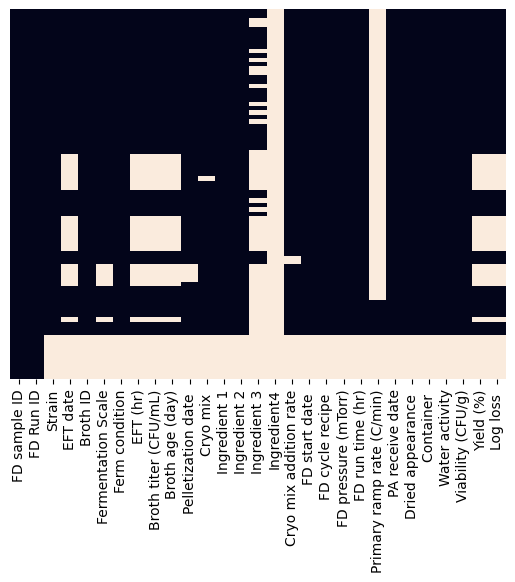

In [16]:
# check NaN values
sns.heatmap(sample_info.isnull(), yticklabels=False, cbar=False)

In [6]:
def cast_df_columns(df):
    """
    The cast_df_columns function takes a dataframe as input and returns the same dataframe with
    the columns that are categorical variables cast to pandas.Categorical dtype. The function also adds
    categories to each column that were not present in the original dataset, but are present in other datasets.

    :param df: Pass in the dataframe to be modified
    :return: The dataframe with the columns casted as categories
    """
    mapping_category_to_col = {
        "Strain": ['Klebsiella variicola', 'Kosakonia sacchari'],
        'Fermentation Scale': ['14L', '150K'],
        'Ingredient 1': ['40% Sucrose', '45.5% Sucrose'],
        'Ingredient 2': ['8% KH2PO4', '10% Maltodextrin', '22.75% Inulin'],
        'Ingredient 3': ['10.2% K2HPO4', '0.5% MgSO4'],
        'Ingredient 4': [],
        'Container': ['Foil pouch']
    }
    for col, categories in mapping_category_to_col.items():
        if col in df.columns:
            df[col] = df[col].astype("category").cat.add_categories(categories)

    return df

In [18]:
# Structure of In-pack df to compose:
inpack_df = pd.read_excel("Data files/PIVOT Sample Master List 2023.xlsm", sheet_name='WP4 In-pack Data')
inpack_df.head()

,Unique ID,FD sample ID,FD Run ID,Strain,Cryo mix,Sub-Sample,Ferm Condition,Storage form,Temperature (°C),Container,...,Rsquared_fitted,decay_rate_errbar,decay_rate_lower95interval,decay_rate_upper95interval,estimate_day_2e10,Week 0 Aw,Week 2 Aw,Week 4 Aw,Week 8 Aw,Week 12 Aw
0,1,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,pellet_21_mylar_n,"Greens, high EPS",Pellet,21,Mylar,...,0.996659,0.000881,-0.008642,-0.006880,168.374192,0.165,NaN,0.175,0.205,NaN
1,2,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,pellet_21_mylar_cacl2,"Greens, high EPS",Pellet,21,Mylar,...,0.939662,0.005588,-0.016840,-0.005663,116.142074,0.165,NaN,0.125,0.153,NaN
2,3,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,unbulked powder_21_mylar_n,"Greens, high EPS",Unbulked powder,21,Mylar,...,0.990339,0.002946,-0.018166,-0.012273,85.502213,0.289,NaN,0.23,0.268,NaN
3,4,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,"bulked powder, pre-dried bulking_21_mylar_n","Greens, high EPS","Bulked powder, pre-dried bulking",21,Mylar,...,0.993116,0.001788,-0.012742,-0.009167,88.342199,0.224,NaN,0.174,0.221,NaN
4,5,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,"bulked powder, w/o sio2_21_mylar_n","Greens, high EPS","Bulked powder, w/o SiO2",21,Mylar,...,0.998539,0.001091,-0.015640,-0.013459,73.940614,0.229,NaN,0.21,0.257,NaN


In [19]:
inpack_df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Unique ID', 'FD sample ID', 'FD Run ID', 'Strain', 'Cryo mix',
       'Sub-Sample', 'Ferm Condition', 'Storage form', 'Temperature (°C)',
       'Container', 'Bulking', 'Desiccant', 'Quantity (g)', 'Sample location',
       'Week 0 CFU/g', 'Week 2 CFU/g', 'Week 4 CFU/g', 'Week 8 CFU/g',
       'Week 12 CFU/g', 'decay_rate_fitted', 'Rsquared_fitted',
       'decay_rate_errbar', 'decay_rate_lower95interval',
       'decay_rate_upper95interval', 'estimate_day_2e10', 'Week 0 Aw',
       'Week 2 Aw', 'Week 4 Aw', 'Week 8 Aw', 'Week 12 Aw'],
      dtype='object')>

In [21]:
inpack_df.drop(['Unique ID','FD sample ID','Quantity (g)','Sample location'],axis=1,inplace=True)

*In-pack* available features:
- Key: FD Run ID
- CFU values by week
- Water activity by week

**Features carry** to *In-pack*:
- Key: **'FD Run ID'** 
- Cols: 'Strain','Cryo mix','Ferm condition','Container', 

**User Inputs** for 'In-pack' (create a new form/table, different from the Sample Info table):
- 'Temperature (°C)', 'Bulking', 'Desiccant', 'Storage form'
    
    Note:
    - Container: foil pouch = Mylar
    - Ferm condition: shorten the description from the "Info"
    
**Features to calculate**
- 'decay_rate_fitted', 'Rsquared_fitted','decay_rate_errbar', 'decay_rate_lower95interval', 'decay_rate_upper95interval', 'estimate_day_2e10'

Questions to team:
- Can 'FD sample ID' be removed? It is not matched up and well recorded at the moment